In [1]:
# ! pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# ! pip install tensorflow-probability
# ! pip install --upgrade tensorflow

In [2]:
# ! pip install --upgrade pandas yaml tensorflow tensorflow-probability ml-collections jraph

In [1]:
import sys, os
sys.path.append("../")

import pandas as pd
import yaml
import jax
import jax.numpy as np
import optax
import flax
from flax.core import FrozenDict
from flax.training import train_state, checkpoints
from ml_collections.config_dict import ConfigDict
import numpy as vnp
import matplotlib.pyplot as plt
import tensorflow as tf

# Ensure TF does not see GPU and grab all GPU memory
tf.config.set_visible_devices([], device_type='GPU')

from tqdm import tqdm, trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

from models.diffusion import VariationalDiffusionModel
from models.diffusion_utils import loss_vdm, sigma2, generate
from models.train_utils import create_input_iter, param_count, train_step
from datasets import load_data

EPS = 1e-7

%load_ext autoreload
%autoreload 2

## Dirs

In [2]:
data_dir = "/n/holyscratch01/iaifi_lab/ccuesta/data_for_sid/"

## My new runs
logging_dir = "/n/holystore01/LABS/iaifi_lab/Lab/set-diffuser-checkpoints/cosmology/"
run_name = "gallant-cherry-87"
# run_name = "leafy-pyramid-88"
# run_name = "effortless-sun-91"

In [3]:
import sys
sys.path.append("../")

from datasets import get_nbody_data
x, _, conditioning, norm_dict = get_nbody_data(n_features=3, n_particles=5000, split="test")

## Load cluster run

In [4]:
config_file = "{}/{}/config.yaml".format(logging_dir, run_name)

with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
    
config = ConfigDict(config)

In [5]:
# Load the dataset
train_ds, norm_dict = load_data(
        config.data.dataset,
        config.data.n_features,
        config.data.n_particles,
        32,
        config.seed,
        shuffle=True,
        split="test",
        #**config.data.kwargs,
    )

batches = create_input_iter(train_ds)

In [6]:
x, conditioning, mask = next(batches)
x = x.reshape(-1, config.data.n_particles, config.data.n_features)
conditioning = conditioning.reshape(-1, 2)
mask = mask.reshape(-1, config.data.n_particles)

In [7]:
# Diffusion model
x_mean = tuple(map(float, norm_dict["mean"]))
x_std = tuple(map(float, norm_dict["std"]))
config.data.apply_pbcs = False
box_size = config.data.box_size #if config.data.apply_pbcs else None
unit_cell = tuple(map(tuple, config.data.unit_cell)) if config.data.apply_pbcs else None

norm_dict_input = FrozenDict(
    {
        "x_mean": x_mean,
        "x_std": x_std,
        "box_size": box_size,
        "unit_cell": unit_cell,
    }
)

In [8]:
print("{} devices visible".format(jax.device_count()))

# Score and (optional) encoder model configs
score_dict = FrozenDict(config.score)
encoder_dict = FrozenDict(config.encoder)
decoder_dict = FrozenDict(config.decoder)

# Diffusion model
vdm = VariationalDiffusionModel(
        d_feature=config.data.n_features,
        timesteps=config.vdm.timesteps,
        noise_schedule=config.vdm.noise_schedule,
        # noise_schedule="linear",
        noise_scale=config.vdm.noise_scale,
        d_t_embedding=config.vdm.d_t_embedding,
        gamma_min=config.vdm.gamma_min,
        gamma_max=config.vdm.gamma_max,
        score=config.score.score,
        score_dict=score_dict,
        embed_context=config.vdm.embed_context,
        d_context_embedding=config.vdm.d_context_embedding,
        n_classes=config.vdm.n_classes,
        use_encdec=config.vdm.use_encdec,
        encoder_dict=encoder_dict,
        decoder_dict=decoder_dict,
        norm_dict=norm_dict_input,
)

# Pass a test batch through to initialize model
x_batch, conditioning_batch, mask_batch = next(batches)
rng = jax.random.PRNGKey(42)
_, params = vdm.init_with_output({"sample": rng, "params": rng}, x_batch[0], conditioning_batch[0], mask_batch[0])

print(f"Params: {param_count(params):,}")

# Training config and state
schedule = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=config.optim.learning_rate, warmup_steps=config.training.warmup_steps, decay_steps=config.training.n_train_steps)
tx = optax.adamw(learning_rate=schedule, weight_decay=config.optim.weight_decay)
if hasattr(config.optim, "grad_clip"):
    if config.optim.grad_clip is not None:
        tx = optax.chain(
            optax.clip(config.optim.grad_clip),
            tx,
        )

state = train_state.TrainState.create(apply_fn=vdm.apply, params=params, tx=tx)

1 devices visible
Params: 637,373


In [9]:
ckpt_dir = "{}/{}/".format(logging_dir, run_name)  # Load SLURM run
restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=state, step=295000)

if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

## Likelihood eval

In [10]:
from functools import partial

In [11]:
def elbo(vdm, params, rng, x, conditioning, mask, steps=20, T=1., unroll_loop=False):
    rng, spl = jax.random.split(rng)
    cond = vdm.apply(params, conditioning, method=vdm.embed)
    f = vdm.apply(params, x, conditioning, method=vdm.encode)
    loss_recon = vdm.apply(params, x, f, conditioning, rngs={"sample": rng}, method=vdm.recon_loss)
    loss_klz = vdm.apply(params, f, method=vdm.latent_loss)
    
    if not unroll_loop:

        def body_fun(i, val):
            loss, rng = val
            rng, spl = jax.random.split(rng)
            new_loss = vdm.apply(params, np.array([i / steps]) * T, f, cond, mask, rngs={"sample": spl}, method=vdm.diffusion_loss)
            return (loss + (new_loss * mask[..., None]).sum((-1, -2)) / steps, rng)

        loss_diff, rng = jax.lax.fori_loop(0, steps, body_fun, (np.zeros(x.shape[0]), rng))

    else:
        
        loss_diff, rng = (np.zeros(x.shape[0]), rng)

        for i in range(steps):
            rng, spl = jax.random.split(rng)
            new_loss = vdm.apply(params, np.array([i / steps]) * T, f, cond, mask, rngs={"sample": spl}, method=vdm.diffusion_loss)
            loss_diff =  loss_diff + (new_loss * mask[..., None]).sum((-1, -2)) / steps

    return ((loss_recon * mask[..., None]).sum((-1, -2)) + (loss_klz * mask[..., None]).sum((-1, -2)) + loss_diff)

In [12]:
@jax.jit
def likelihood(theta_test, x_test, n_samples=8, steps=30, T=1.):
    x_test = np.repeat(np.array([x_test]), n_samples, 0)
    theta_test = np.repeat(np.array([theta_test]), n_samples, 0)
    return -elbo(vdm, restored_state.params, rng, x_test, theta_test, np.ones_like(x_test[..., 0]), steps=steps, T=T).mean()

In [13]:
idx = 16

x_test = x[idx]

Omega_m = conditioning[idx][0]
sigma_8 = conditioning[idx][1]

theta_test = np.array([Omega_m, sigma_8])
likelihood(theta_test, x_test)

Array(-20602.727, dtype=float32)

In [14]:
sigma_8_ary = np.linspace(0.6, 1.0, 30)
omega_m_ary = np.linspace(0.1, 0.5, 30)

In [82]:
log_like = []

for sigma_8 in tqdm(sigma_8_ary):
    theta_test = np.array([conditioning[idx][0], sigma_8])
    log_like.append(likelihood(theta_test, x_test))

100%|█████████████████████████| 30/30 [00:18<00:00,  1.60it/s]


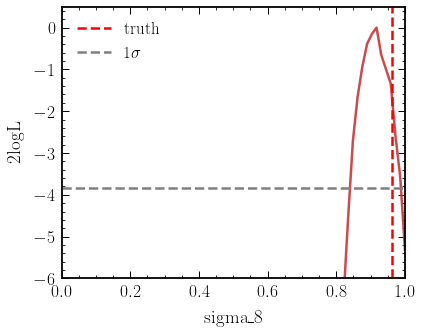

In [83]:
from scipy.stats import chi2

plt.plot(sigma_8_ary, 2 * (np.array(log_like) - np.max(np.array(log_like))))
plt.axvline(conditioning[idx][-1], ls='--', label="truth", color='red')
plt.xlim(0, 1)
plt.ylim(-6, 0.5)

plt.axhline(-chi2.isf(1 - .95, 1), ls = '--', color='grey', label="$1\sigma$")

plt.ylabel(r"2logL")
plt.xlabel(r"sigma_8")

plt.legend()

In [84]:
log_like = []

for omega_m in tqdm(omega_m_ary):
    theta_test = np.array([omega_m, conditioning[idx][1]])
    log_like.append(likelihood(theta_test, x_test))

100%|█████████████████████████| 30/30 [00:18<00:00,  1.60it/s]


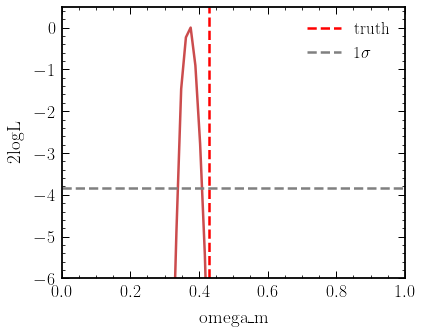

In [85]:
from scipy.stats import chi2

plt.plot(omega_m_ary, 2 * (np.array(log_like) - np.max(np.array(log_like))))
plt.axvline(conditioning[idx][0], ls='--', label="truth", color='red')
plt.xlim(0, 1)
plt.ylim(-6, 0.5)

plt.axhline(-chi2.isf(1 - .95, 1), ls = '--', color='grey', label="$1\sigma$")

plt.ylabel(r"2logL")
plt.xlabel(r"omega_m")

plt.legend()

In [15]:
n_test = 32

log_like_cov = []
for idx in tqdm(range(n_test)):
    log_like = []
    x_test = x[idx]
    for omega_m in omega_m_ary:
        theta_test = np.array([omega_m, conditioning[idx][1]])
        log_like.append(likelihood(theta_test, x_test))
    log_like_cov.append(log_like)
log_like_cov = np.array(log_like_cov)

100%|███████████████████████████████████████████| 32/32 [57:56<00:00, 108.64s/it]


In [16]:
from scipy.stats import chi2

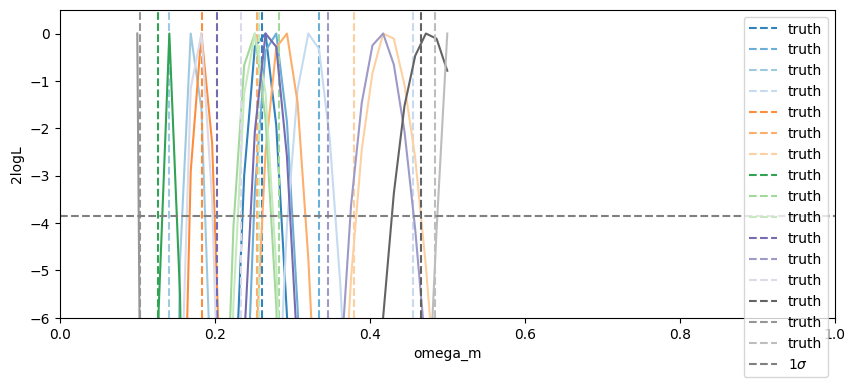

In [17]:
plt.figure(figsize=(10, 4))

i_ = 0
n_test_max = 16
for ic, idx in enumerate(range(i_,i_ + n_test_max)):
    if conditioning[idx][0] > 0.1:
        plt.plot(omega_m_ary, 2 * (np.array(log_like_cov[idx]) - np.max(np.array(log_like_cov[idx]))), color=plt.cm.tab20c(ic / n_test_max))
        plt.axvline(conditioning[idx][0], ls='--', label="truth", color=plt.cm.tab20c(ic / n_test_max))
        # print(conditioning[idx][0])

plt.xlim(0, 1)
plt.ylim(-6, 0.5)

plt.axhline(-chi2.isf(1 - .95, 1), ls = '--', color='grey', label="$1\sigma$")

plt.ylabel(r"2logL")
plt.xlabel(r"omega_m")

plt.legend()

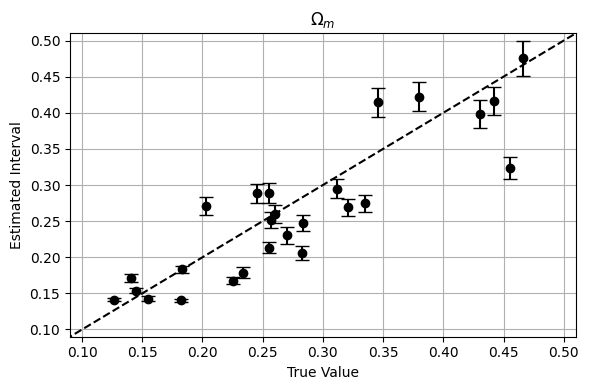

In [18]:
from scipy.interpolate import interp1d

i_ = 0
n_test_max = 32
threshold_1sigma = -chi2.isf(1 - .68, 1)

intervals1 = []  # store intervals here
true_values = []  # store true values here

for ic, idx in enumerate(range(i_, i_ + n_test_max)):
    if conditioning[idx][0] < 0.12 or conditioning[idx][0] > 0.48:
        continue
        
    likelihood_arr = 2 * (np.array(log_like_cov[idx]) - np.max(np.array(log_like_cov[idx])))

    # Interpolate to find the 95% limits
    f_interp1 = interp1d(omega_m_ary, likelihood_arr - threshold_1sigma, kind='linear', fill_value="extrapolate")
    x_vals = np.linspace(omega_m_ary[0], omega_m_ary[-1], 1000)
    diff_signs1 = np.sign(f_interp1(x_vals))

    # Find where the sign changes
    sign_changes1 = ((diff_signs1[:-1] * diff_signs1[1:]) < 0).nonzero()[0]

    if len(sign_changes1) >= 2:  # We need at least two crossings
        intervals1.append((x_vals[sign_changes1[0]], x_vals[sign_changes1[-1]]))
        true_values.append(conditioning[idx][0])
    else:
        # Handle the case where no interval is found

        if x_vals[sign_changes1[0]] > 0.3:
            intervals1.append((x_vals[sign_changes1[0]], omega_m_ary[-1]))
            true_values.append(conditioning[idx][0])
        else:
            intervals1.append((omega_m_ary[0], x_vals[sign_changes1[0]]))
            true_values.append(conditioning[idx][0])
        

# Plotting true value vs. interval
plt.figure(figsize=(6, 4))

for value, (low, high) in zip(true_values, intervals1):
    plt.errorbar(value, (low + high) / 2., yerr=[[(low + high) / 2. - low], [high - (low + high) / 2.]], fmt='o', capsize=5, color='k')

plt.plot([0,1],[0,1], color='k', ls='--')

plt.xlim(0.09, 0.51)
plt.ylim(0.09, 0.51)

plt.title("$\Omega_m$")

plt.xlabel("True Value")
plt.ylabel("Estimated Interval")
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
log_like_cov_s8 = []
for idx in tqdm(range(n_test)):
    log_like = []
    x_test = x[idx]
    for sigma_8 in sigma_8_ary:
        theta_test = np.array([conditioning[idx][0], sigma_8])
        log_like.append(likelihood(theta_test, x_test))
    log_like_cov_s8.append(log_like)
log_like_cov_s8 = np.array(log_like_cov_s8)

100%|███████████████████████████████████████████| 32/32 [57:54<00:00, 108.57s/it]


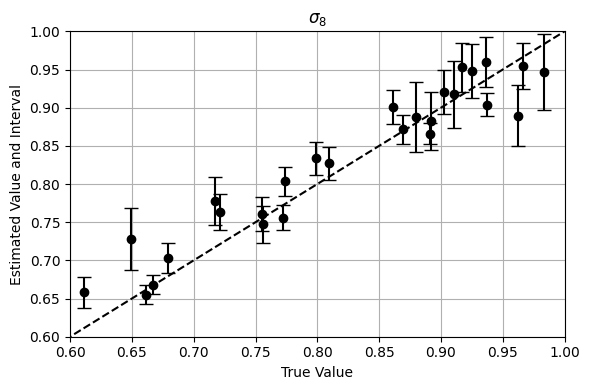

In [20]:
from scipy.interpolate import interp1d

i_ = 0
n_test_max = 32
threshold_1sigma = -chi2.isf(1 - .68, 1)
threshold_2sigma = -chi2.isf(1 - .95, 1)

intervals1 = []  # store intervals here
true_values = []  # store true values here

for ic, idx in enumerate(range(i_, i_ + n_test_max)):
    # if conditioning[idx][0] > 0.1:
    likelihood_arr = 2 * (np.array(log_like_cov_s8[idx]) - np.max(np.array(log_like_cov_s8[idx])))

    # Interpolate to find the 95% limits
    f_interp1 = interp1d(sigma_8_ary, likelihood_arr - threshold_1sigma, kind='linear', fill_value="extrapolate")
    f_interp2 = interp1d(sigma_8_ary, likelihood_arr - threshold_2sigma, kind='linear', fill_value="extrapolate")
    x_vals = np.linspace(sigma_8_ary[0], sigma_8_ary[-1], 1000)
    diff_signs1 = np.sign(f_interp1(x_vals))
    diff_signs2 = np.sign(f_interp2(x_vals))

    # Find where the sign changes
    sign_changes1 = ((diff_signs1[:-1] * diff_signs1[1:]) < 0).nonzero()[0]

    if len(sign_changes1) >= 2:  # We need at least two crossings
        intervals1.append((x_vals[sign_changes1[0]], x_vals[sign_changes1[-1]]))
        true_values.append(conditioning[idx][1])
    else:
        # Optionally handle the case where no interval is found
        pass

# Plotting true value vs. interval
plt.figure(figsize=(6, 4))

for value, (low, high) in zip(true_values, intervals1):
    plt.errorbar(value, (low + high) / 2., yerr=[[(low + high) / 2. - low], [high - (low + high) / 2.]], fmt='o', capsize=5, color='k')

plt.plot([0,1],[0,1], color='k', ls='--')

plt.xlim(0.6, 1.)
plt.ylim(0.6, 1.)

plt.title("$\sigma_8$")

plt.xlabel("True Value")
plt.ylabel("Estimated Value and Interval")
plt.grid(True)
plt.tight_layout()
plt.show()

In [91]:
np.savez("data/ll_profs.npz",
         log_like_cov=log_like_cov,
         log_like_cov_s8=log_like_cov_s8,
         sigma_8_ary=sigma_8_ary,
         omega_m_ary=omega_m_ary,
         conditioning=conditioning)

## Plot

In [92]:
ll_profs_npz = np.load("data/ll_profs.npz")
log_like_cov = ll_profs_npz['log_like_cov']
log_like_cov_s8 = ll_profs_npz['log_like_cov_s8']
sigma_8_ary = ll_profs_npz['sigma_8_ary']
omega_m_ary = ll_profs_npz['omega_m_ary']
conditioning = ll_profs_npz['conditioning']

ll_profs_vel_npz = np.load("data/ll_profs_vel.npz")
log_like_cov_vel = ll_profs_vel_npz['log_like_cov']
log_like_cov_vel_s8 = ll_profs_vel_npz['log_like_cov_s8']
sigma_8_vel_ary = ll_profs_vel_npz['sigma_8_ary']
omega_m_vel_ary = ll_profs_vel_npz['omega_m_ary']
conditioning_vel = ll_profs_vel_npz['conditioning']

In [93]:
from matplotlib import cm
cmap = cm.get_cmap('viridis_r')

import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

import logging
import matplotlib

logging.getLogger('matplotlib').setLevel(logging.ERROR)

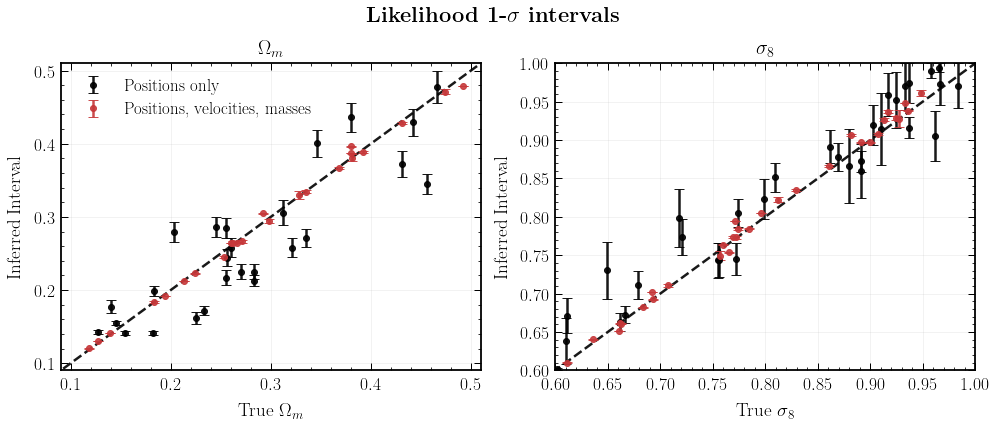

In [96]:
from scipy.interpolate import interp1d
from scipy.stats import chi2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

### Positions

i_ = 0
n_test_max = 32
threshold_1sigma = -chi2.isf(1 - .68, 1)

## Omega_m

intervals1 = []  # store intervals here
true_values = []  # store true values here

for ic, idx in enumerate(range(i_, i_ + n_test_max)):
    if conditioning[idx][0] < 0.12 or conditioning[idx][0] > 0.48:
        continue
        
    likelihood_arr = 2 * (np.array(log_like_cov[idx]) - np.max(np.array(log_like_cov[idx])))

    # Interpolate to find the 95% limits
    f_interp1 = interp1d(omega_m_ary, likelihood_arr - threshold_1sigma, kind='linear', fill_value="extrapolate")
    x_vals = np.linspace(omega_m_ary[0], omega_m_ary[-1], 1000)
    diff_signs1 = np.sign(f_interp1(x_vals))

    # Find where the sign changes
    sign_changes1 = ((diff_signs1[:-1] * diff_signs1[1:]) < 0).nonzero()[0]

    if len(sign_changes1) >= 2:  # We need at least two crossings
        intervals1.append((x_vals[sign_changes1[0]], x_vals[sign_changes1[-1]]))
        true_values.append(conditioning[idx][0])
    else:
        # Handle the case where no interval is found

        if x_vals[sign_changes1[0]] > 0.3:
            intervals1.append((x_vals[sign_changes1[0]], omega_m_ary[-1]))
            true_values.append(conditioning[idx][0])
        else:
            intervals1.append((omega_m_ary[0], x_vals[sign_changes1[0]]))
            true_values.append(conditioning[idx][0])
        
for idx, (value, (low, high)) in enumerate(zip(true_values, intervals1)):
    ax1.errorbar(value, (low + high) / 2., yerr=[[(low + high) / 2. - low], [high - (low + high) / 2.]], fmt='o', capsize=5, color='k', label="Positions only" if idx == 0 else None)

ax1.plot([0,1],[0,1], color='k', ls='--')

ax1.set_xlim(0.09, 0.51)
ax1.set_ylim(0.09, 0.51)

ax1.set_title("$\Omega_m$", y=1.01, fontsize=20)

ax1.set_xlabel("True $\Omega_m$")
ax1.set_ylabel("Inferred Interval")

## Sigma_8

intervals1 = []  # store intervals here
true_values = []  # store true values here

for ic, idx in enumerate(range(i_, i_ + n_test_max)):
    
    likelihood_arr = 2 * (np.array(log_like_cov_s8[idx]) - np.max(np.array(log_like_cov_s8[idx])))

    # Interpolate to find the 95% limits
    f_interp1 = interp1d(sigma_8_ary, likelihood_arr - threshold_1sigma, kind='linear', fill_value="extrapolate")
    x_vals = np.linspace(sigma_8_ary[0], sigma_8_vel_ary[-1], 1000)
    diff_signs1 = np.sign(f_interp1(x_vals))

    # Find where the sign changes
    sign_changes1 = ((diff_signs1[:-1] * diff_signs1[1:]) < 0).nonzero()[0]

    if len(sign_changes1) >= 2:  # We need at least two crossings
        intervals1.append((x_vals[sign_changes1[0]], x_vals[sign_changes1[-1]]))
        true_values.append(conditioning[idx][1])
    else:
        # Optionally handle the case where no interval is found
        
        if x_vals[sign_changes1[0]] > 0.8:
            intervals1.append((x_vals[sign_changes1[0]], sigma_8_ary[-1]))
            true_values.append(conditioning[idx][1])
        else:
            intervals1.append((sigma_8_ary[0], x_vals[sign_changes1[0]]))
            true_values.append(conditioning[idx][1])

for value, (low, high) in zip(true_values, intervals1):
    ax2.errorbar(value, (low + high) / 2., yerr=[[(low + high) / 2. - low], [high - (low + high) / 2.]], fmt='o', capsize=5, color='k')

ax2.plot([0,1],[0,1], color='k', ls='--')

ax2.set_xlim(0.6, 1.0)
ax2.set_ylim(0.6, 1.0)

ax2.set_title("$\sigma_8$", y=1.01, fontsize=20)

ax2.set_xlabel("True $\sigma_8$")
ax2.set_ylabel("Inferred Interval")

### Velocities

## Omega_m

intervals1 = []  # store intervals here
true_values = []  # store true values here

for ic, idx in enumerate(range(i_, i_ + n_test_max)):
    if conditioning[idx][0] < 0.12 or conditioning[idx][0] > 0.48:
        continue
        
    likelihood_arr = 2 * (np.array(log_like_cov_vel[idx]) - np.max(np.array(log_like_cov_vel[idx])))

    # Interpolate to find the 95% limits
    f_interp1 = interp1d(omega_m_vel_ary, likelihood_arr - threshold_1sigma, kind='linear', fill_value="extrapolate")
    x_vals = np.linspace(omega_m_vel_ary[0], omega_m_ary[-1], 1000)
    diff_signs1 = np.sign(f_interp1(x_vals))

    # Find where the sign changes
    sign_changes1 = ((diff_signs1[:-1] * diff_signs1[1:]) < 0).nonzero()[0]

    if len(sign_changes1) >= 2:  # We need at least two crossings
        intervals1.append((x_vals[sign_changes1[0]], x_vals[sign_changes1[-1]]))
        true_values.append(conditioning_vel[idx][0])
    else:
        # Handle the case where no interval is found

        if len(sign_changes1) == 1:
            if x_vals[sign_changes1[0]] > 0.3:
                intervals1.append((x_vals[sign_changes1[0]], omega_m_ary[-1]))
                true_values.append(conditioning_vel[idx][0])
            else:
                intervals1.append((omega_m_ary[0], x_vals[sign_changes1[0]]))
                true_values.append(conditioning_vel[idx][0])
        else:
            pass
            
for idx, (value, (low, high)) in enumerate(zip(true_values, intervals1)):
    ax1.errorbar(value, (low + high) / 2., yerr=[[(low + high) / 2. - low], [high - (low + high) / 2.]], fmt='o', capsize=5, color=cols_default[0], label="Positions, velocities, masses" if idx == 0 else None)


## Sigma_8

intervals1 = []  # store intervals here
true_values = []  # store true values here

for ic, idx in enumerate(range(i_, i_ + n_test_max)):
    
    likelihood_arr = 2 * (np.array(log_like_cov_vel_s8[idx]) - np.max(np.array(log_like_cov_vel_s8[idx])))

    # Interpolate to find the 95% limits
    f_interp1 = interp1d(sigma_8_vel_ary, likelihood_arr - threshold_1sigma, kind='linear', fill_value="extrapolate")
    x_vals = np.linspace(sigma_8_vel_ary[0], sigma_8_vel_ary[-1], 1000)
    diff_signs1 = np.sign(f_interp1(x_vals))

    # Find where the sign changes
    sign_changes1 = ((diff_signs1[:-1] * diff_signs1[1:]) < 0).nonzero()[0]

    if len(sign_changes1) >= 2:  # We need at least two crossings
        intervals1.append((x_vals[sign_changes1[0]], x_vals[sign_changes1[-1]]))
        true_values.append(conditioning_vel[idx][1])
    else:
        # Optionally handle the case where no interval is found
        pass

for value, (low, high) in zip(true_values, intervals1):
    ax2.errorbar(value, (low + high) / 2., yerr=[[(low + high) / 2. - low], [high - (low + high) / 2.]], fmt='o', capsize=5, color=cols_default[0])

plt.suptitle(r"\bf{Likelihood 1-$\sigma$ intervals}", fontsize=22)

ax1.grid(True, alpha=0.2)
ax2.grid(True, alpha=0.2)

ax1.legend(loc='upper left')

plt.tight_layout()
plt.savefig("plots/ll_prof.pdf")

## Sampling with PF-ODE

In [163]:
from models.diffusion_utils import gamma, sigma2
import diffrax as dfx

In [164]:
def single_sample_fn(vdm, params, conditioning, mask, data_shape, dt0, t1, t0, key):


    def int_beta(t):
        return np.log(1 + np.exp(-vdm.apply(params, t, method=vdm.gammat)))    
    
    def beta(t):
        _, beta = jax.jvp(int_beta, (t,), (np.ones_like(t),))
        return beta

    @jax.jit
    def drift(t, y, args):

        y = y[None, ...]
        t = np.atleast_1d(t)

        beta_t = beta(t)
        g_t = vdm.apply(params, t, method=vdm.gammat)
        sigma2_t = sigma2(g_t)
        
        f = -0.5 * beta_t * y 
        g2 = beta_t
                
        eps = vdm.apply(params, y, g_t, conditioning[None, ...], mask[None, ...], method=vdm.score_eval)
        
        score = -eps / np.sqrt(sigma2_t)
        return (f - 0.5 * g2 * score)[0]

    term = dfx.ODETerm(drift)
    solver = dfx.Heun()
    y1 = jax.random.normal(key, data_shape)
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1)
    return sol.ys[0]

dt = 1e-2
key = jax.random.PRNGKey(4)
T = 1.
t0 = 0.

x_single_sample = single_sample_fn(vdm, restored_state.params, conditioning[0], mask[0], (5000, 3), dt, T, t0, key)

Text(0.5, 0, 'z')

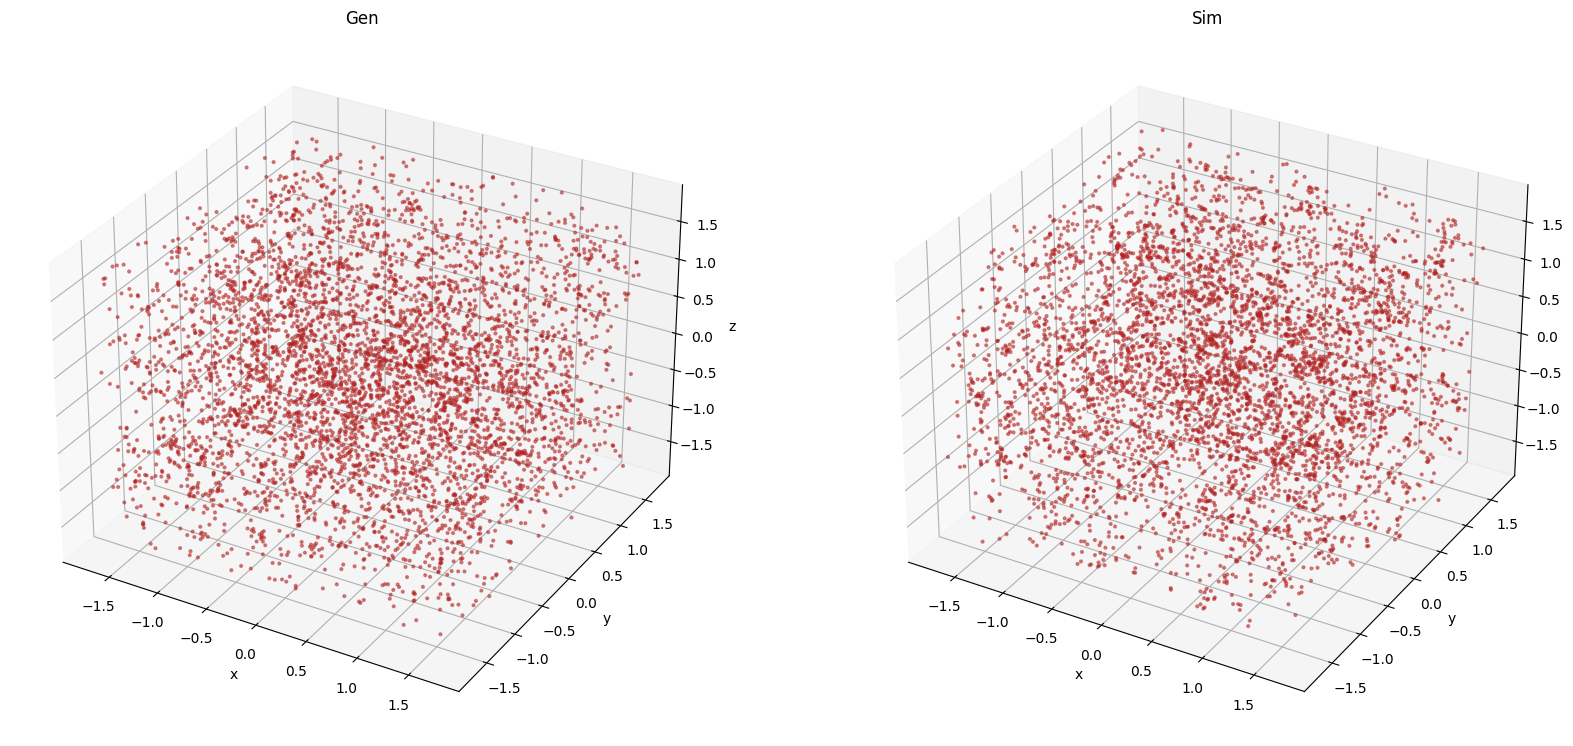

In [165]:
idx = 0

s = 4
alpha = 0.5
color = "firebrick"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12), subplot_kw={'projection':'3d'})

ax1.scatter(x_single_sample[:, 0], x_single_sample[:, 1], x_single_sample[:, 2], alpha=alpha, s=s, color=color);
ax1.set_title("Gen")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

ax2.scatter(x[idx_rnd[idx], :, 0], x[idx_rnd[idx], :, 1], x[idx_rnd[idx], :, 2], alpha=alpha, s=s, color=color);
ax2.set_title("Sim")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")

## Likelihood evaluation with PF-ODE

See another implementation here: https://colab.research.google.com/drive/1SeXMpILhkJPjXUaesvzEhc3Ke6Zl_zxJ?usp=sharing#scrollTo=DfOkg5jBZcjF

Current issue: Trace estimator is extremely susceptible to RNG.

In [166]:
from diffrax import PIDController

@jax.jit
def likelihood(params, y, conditioning, mask, key, dt0):

    def int_beta(t):
        return np.log(1 + np.exp(-vdm.apply(params, t, method=vdm.gammat)))    
    
    def beta(t):
        _, beta = jax.jvp(int_beta, (t,), (np.ones_like(t),))
        return beta

    def drift(t, y):
        y = y[None, ...]
        t = np.atleast_1d(t)

        beta_t = beta(t)
        g_t = vdm.apply(params, t, method=vdm.gammat)
        sigma2_t = sigma2(g_t)
        
        f = -0.5 * beta_t * y 
        g2 = beta_t
                
        eps = vdm.apply(params, y, g_t, conditioning[None, ...], mask[None, ...], method=vdm.score_eval)
        
        score = -eps / np.sqrt(sigma2_t)
        return (f - 0.5 * g2 * score)[0]

    def logp(t, y, args):
        """ Approx. trace using Hutchinson's trace estimator.
        """
        y, _ = y
        (eps,) = args
        t = np.atleast_1d(t)
        
        fn = lambda y: drift(t, y)
        f, f_vjp = jax.vjp(fn, y)
        
        # Trace estimator
        (eps_dfdy,) = f_vjp(eps)
        logp = np.sum(eps_dfdy * eps)
        return f, logp

    term = dfx.ODETerm(logp)
    solver = dfx.Dopri5()

    ## Noise for Hutchinson trace estimator
    # eps = jax.random.normal(key, y.shape)  # Gaussian
    eps = jax.random.randint(key, y.shape, minval=0, maxval=2).astype(np.float32) * 2 - 1  # Rademacher
    delta_log_likelihood = 0.0
    y = (y, delta_log_likelihood)
    t_eps = 1e-3  # Start at small value for numerical stability
    g_1 = vdm.apply(params, 1., method=vdm.gammat)  # Get variance at T=1  
    sigma2_1 = sigma2(g_1)
    stepsize_controller = dfx.PIDController(atol=1e-3, rtol=1e-3)
    sol = dfx.diffeqsolve(term, solver, t_eps, 1., dt0, y, (eps,), stepsize_controller=stepsize_controller)
    (z,), (delta_log_likelihood,) = sol.ys
    log_prob = delta_log_likelihood + tfp.distributions.Normal(loc=0., scale=np.sqrt(sigma2_1)).log_prob(z).sum()
    return log_prob

In [67]:
idx = 0  # Has a bias in omega_m

x_test = x[idx]

Omega_m = conditioning[idx][0]
sigma_8 = conditioning[idx][1]

key = jax.random.PRNGKey(43)

theta_test = np.array([Omega_m, sigma_8])
likelihood(restored_state.params, x_test, theta_test, mask[0], key, 0.1)

Array(-17380.012, dtype=float32)

In [68]:
key = jax.random.PRNGKey(54)

theta_test = np.array([Omega_m, sigma_8])
likelihood(restored_state.params, x_test, theta_test, mask[0], key, 0.1)

Array(-17464.541, dtype=float32)

In [60]:
sigma_8_ary = np.linspace(0.6, 1.0, 30)

log_like = []

for sigma_8 in tqdm(sigma_8_ary):
    theta_test = np.array([conditioning[idx][0], sigma_8])
    log_like.append(likelihood(restored_state.params, x_test, theta_test, mask[0], key, 0.2))

100%|███████████████████████████████████████████████████████████| 30/30 [04:14<00:00,  8.49s/it]


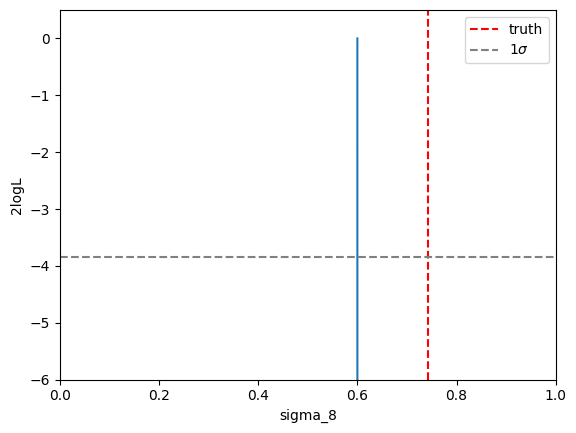

In [61]:
from scipy.stats import chi2

plt.plot(sigma_8_ary, 2 * (np.array(log_like) - np.max(np.array(log_like))))
plt.axvline(conditioning[idx][-1], ls='--', label="truth", color='red')
plt.xlim(0, 1)
plt.ylim(-6, 0.5)

plt.axhline(-chi2.isf(1 - .95, 1), ls = '--', color='grey', label="$1\sigma$")

plt.ylabel(r"2logL")
plt.xlabel(r"sigma_8")

plt.legend()